CNN mobileNet

In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
from keras.utils.io_utils import HDF5Matrix
from tensorflow import keras

Show the dataset and different field we can work with

In [24]:
h5_path = 'E:/_DOWNLOADED/chest.h5'
disease_vec_labels = ['Atelectasis','Cardiomegaly','Consolidation','Edema','Effusion','Emphysema','Fibrosis',
 'Hernia','Infiltration','Mass','Nodule','Pleural_Thickening','Pneumonia','Pneumothorax']
disease_vec = []
with h5py.File(h5_path, 'r') as h5_data:
    all_fields = list(h5_data.keys())
    for c_key in all_fields:
        print(c_key, h5_data[c_key].shape, h5_data[c_key].dtype)
    for c_key in disease_vec_labels:
        disease_vec += [h5_data[c_key][:]]
disease_vec = np.stack(disease_vec,1)
print('Disease Vec:', disease_vec.shape)

Atelectasis (18000,) float64
Cardiomegaly (18000,) float64
Consolidation (18000,) float64
Edema (18000,) float64
Effusion (18000,) float64
Emphysema (18000,) float64
Fibrosis (18000,) float64
Finding Labels (18000,) |S100
Follow-up # (18000,) int64
Hernia (18000,) float64
Image Index (18000,) |S16
Infiltration (18000,) float64
Mass (18000,) float64
Nodule (18000,) float64
OriginalImageHeight (18000,) int64
OriginalImagePixelSpacing_x (18000,) float64
OriginalImagePixelSpacing_y (18000,) float64
OriginalImageWidth (18000,) int64
Patient Age (18000,) int64
Patient Gender (18000,) |S1
Patient ID (18000,) int64
Pleural_Thickening (18000,) float64
Pneumonia (18000,) float64
Pneumothorax (18000,) float64
View Position (18000,) |S2
images (18000, 128, 128, 1) uint8
path (18000,) |S43
Disease Vec: (18000, 14)


In [25]:
img_ds = HDF5Matrix(h5_path, 'images')
split_idx = img_ds.shape[0]//2
train_ds = HDF5Matrix(h5_path, 'images', end = split_idx)
test_ds = HDF5Matrix(h5_path, 'images', start = split_idx)
train_dvec = disease_vec[0:split_idx]
test_dvec = disease_vec[split_idx:]
print('Train Shape', train_ds.shape, 'test shape', test_ds.shape)

Train Shape (9000, 128, 128, 1) test shape (9000, 128, 128, 1)


In [26]:
keras.backend.clear_session()

In [27]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D
raw_model = MobileNet(input_shape=(None, None, 1), include_top = False, weights = None)
full_model = Sequential()
full_model.add(AveragePooling2D((2,2), input_shape = img_ds.shape[1:]))
full_model.add(BatchNormalization())
full_model.add(raw_model)
full_model.add(Flatten())
full_model.add(Dropout(0.5))
full_model.add(Dense(64))
full_model.add(Dense(disease_vec.shape[1], activation = 'relu'))
full_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
full_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d (AveragePo (None, 64, 64, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 1)         4         
_________________________________________________________________
mobilenet_1.00_None (Functio (None, None, None, 1024)  3228288   
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                262208    
_________________________________________________________________
dense_1 (Dense)              (None, 14)                9

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
file_path="E:/_DOWNLOADED/bestw_original.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=2, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5)
callbacks_list = [checkpoint, early] #early

In [29]:
history = full_model.fit(train_ds, train_dvec, 
               validation_data = (test_ds, test_dvec),
               epochs=10, 
               verbose = True,
              shuffle = 'batch',
              callbacks = callbacks_list)

Epoch 1/10
281/282 [============================>.] - ETA: 0s - loss: 1.9958 - acc: 0.3313WARNING:tensorflow:Keras is training/fitting/evaluating on array-like data. Keras may not be optimized for this format, so if your input data format is supported by TensorFlow I/O (https://github.com/tensorflow/io) we recommend using that to load a Dataset instead.

Epoch 00001: val_acc improved from -inf to 0.31989, saving model to E:/_DOWNLOADED\bestw_original.hdf5
282/282 [==============================] - 5s 19ms/step - loss: 1.9958 - acc: 0.3309 - val_loss: 1.7984 - val_acc: 0.3199
Epoch 2/10
280/282 [============================>.] - ETA: 0s - loss: 1.9777 - acc: 0.3365
Epoch 00002: val_acc did not improve from 0.31989
282/282 [==============================] - 5s 17ms/step - loss: 1.9773 - acc: 0.3366 - val_loss: 1.7984 - val_acc: 0.3199
Epoch 3/10
281/282 [============================>.] - ETA: 0s - loss: 1.9771 - acc: 0.3364
Epoch 00003: val_acc did not improve from 0.31989
282/282 [=====

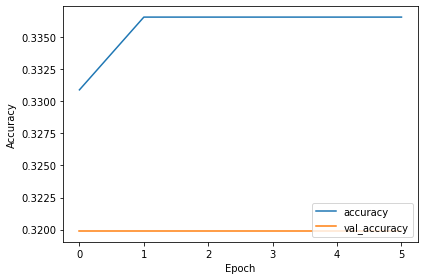

In [31]:


plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

plt.tight_layout()


In [32]:
test_loss, test_acc = full_model.evaluate(test_ds, test_dvec, verbose=2)
print("Test accuracy: ",test_acc," Test loss: ",test_loss)

282/282 - 1s - loss: 1.7984 - acc: 0.3199
Test accuracy:  0.3198888897895813  Test loss:  1.7983527183532715
